<a href="https://colab.research.google.com/github/Rainniee/Neural-Networks-AI/blob/master/Experiment2_GloVe%20%26%20Transfer%20Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
from __future__ import division
from __future__ import print_function

import pandas as pd
import numpy as np

import itertools
import os

import nltk
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix, accuracy_score

from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from keras import optimizers

%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.keras.datasets import imdb
from tensorflow import keras
from keras.layers import Embedding, Flatten, Dense, SimpleRNN, LSTM, Activation, Dropout
from keras.layers import LSTM, CuDNNLSTM

from keras import regularizers
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D 

from keras import optimizers
from keras.models import Sequential
from keras.models import load_model
from keras.preprocessing import text, sequence
from keras import utils
from tensorflow.keras.callbacks import EarlyStopping

# This code was tested with TensorFlow v1.4
print("You have TensorFlow version", tf.__version__)

from distutils.version import LooseVersion as LV
from keras import __version__
from keras import backend as K

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import seaborn as sns
sns.set()

You have TensorFlow version 1.13.1


### Load the IMDB Dataset

In [2]:
# number of most-frequent words to use
nb_words = 10000
# cut texts after this number of words
maxlen = 1000

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=nb_words)
print('x_train:', x_train.shape)
print('x_test:', x_test.shape)
print()

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Loading data...
17465344/17464789 [==============================] - 1s 0us/step
x_train: (25000,)
x_test: (25000,)

Pad sequences (samples x time)
x_train shape: (25000, 1000)
x_test shape: (25000, 1000)


### Doawload the GloVe

In [3]:
if not os.path.exists('glove.6B.zip'):
    ! wget http://nlp.stanford.edu/data/glove.6B.zip
if not os.path.exists('glove.6B.50d.txt'):
    ! unzip glove.6B.zip

--2019-03-28 06:36:12--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-03-28 06:36:12--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.57MB/s    in 4m 6s   

2019-03-28 06:40:19 (3.34 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [4]:
vocab_size = 5000
embedding_size = 50
word_index = imdb.get_word_index()

def load_glove_embeddings(path):
    embeddings = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            w = values[0]
            vectors = np.asarray(values[1:], dtype='float32')
            embeddings[w] = vectors

    embedding_matrix = np.random.uniform(-1, 1, size=(vocab_size, embedding_size))
    num_loaded = 0
    for w, i in word_index.items():
        v = embeddings.get(w)
        if v is not None and i < vocab_size:
            embedding_matrix[i] = v
            num_loaded += 1
    print('Successfully loaded pretrained embeddings for '
          f'{num_loaded}/{vocab_size} words.')
    embedding_matrix = embedding_matrix.astype(np.float32)
    return embedding_matrix

embedding_matrix = load_glove_embeddings('glove.6B.50d.txt')

1646592/1641221 [==============================] - 0s 0us/step
Successfully loaded pretrained embeddings for 4920/5000 words.


In [12]:
max_words = 5000
embedding_dims = 50
maxlen = 1000

model = Sequential()
model.add(Embedding(max_words,
                    embedding_dims,
                    weights = [embedding_matrix],
                    trainable = False,
                    input_length=maxlen))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 1000, 50)          250000    
_________________________________________________________________
dropout_4 (Dropout)          (None, 1000, 50)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 50000)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                1600032   
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 1,850,065
Trainable params: 1,600,065
Non-trainable params: 250,000
_________________________________________________________________


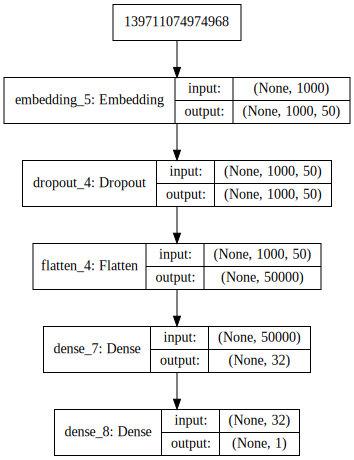

In [13]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

### Train the Model

In [15]:
%%time
epochs = 5
validation_split = 0.2

history = model.fit(x_train, y_train, batch_size=128,
          epochs=epochs, 
          validation_split=validation_split)

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 2s 85us/step - loss: 8.0840 - acc: 0.4985 - val_loss: 7.9591 - val_acc: 0.5062
Epoch 2/5
20000/20000 [==============================] - 2s 79us/step - loss: 8.0840 - acc: 0.4985 - val_loss: 7.9591 - val_acc: 0.5062
Epoch 3/5
20000/20000 [==============================] - 2s 79us/step - loss: 8.0840 - acc: 0.4985 - val_loss: 7.9591 - val_acc: 0.5062
Epoch 4/5
20000/20000 [==============================] - 2s 80us/step - loss: 8.0840 - acc: 0.4985 - val_loss: 7.9591 - val_acc: 0.5062
Epoch 5/5
20000/20000 [==============================] - 2s 79us/step - loss: 8.0840 - acc: 0.4985 - val_loss: 7.9591 - val_acc: 0.5062
CPU times: user 6.28 s, sys: 1.33 s, total: 7.61 s
Wall time: 8.04 s


In [17]:
score, acc = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (acc*100))

Accuracy: 50.00%


0.5
              precision    recall  f1-score   support

         pos       0.50      1.00      0.67     12500
         neg       0.00      0.00      0.00     12500

   micro avg       0.50      0.50      0.50     25000
   macro avg       0.25      0.50      0.33     25000
weighted avg       0.25      0.50      0.33     25000

[[12500     0]
 [12500     0]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


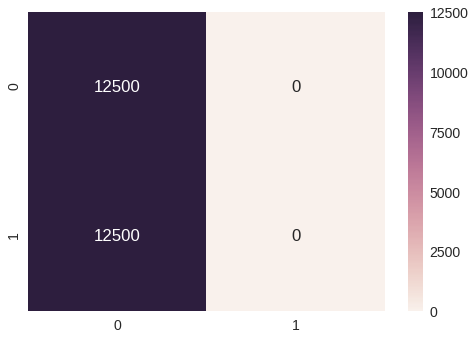

In [18]:
import pandas as pd
import seaborn as sns

from sklearn.metrics import classification_report,confusion_matrix
y_pred = model.predict_classes(np.array(x_test))

from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred))
target_names = ['pos', 'neg']
cnf_matrix_test = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred, target_names=target_names))
print(cnf_matrix_test)

df_cm = pd.DataFrame(cnf_matrix_test, range(2), range(2))

sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, fmt='d')


### CNN With GloVe

In [25]:
num_filters = 64 
max_words = 5000
embedding_dims = 50
maxlen = 1000
weight_decay = 1e-4

model = Sequential()
model.add(Embedding(max_words,
                    embedding_dims,
                    weights = [embedding_matrix],
                    input_length=maxlen))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(1, activation='sigmoid'))  

model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=0.001), metrics=['accuracy'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 1000, 50)          250000    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1000, 64)          22464     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 500, 64)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 500, 64)           28736     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 32)                2080      
__________

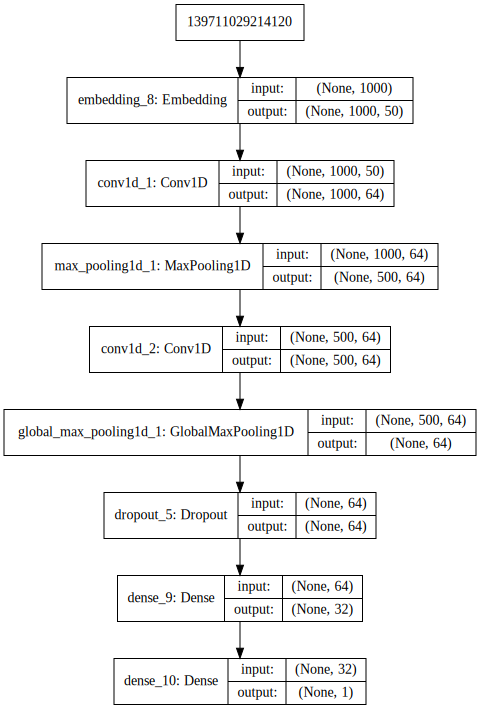

In [23]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [26]:
%%time
epochs = 10
validation_split = 0.2

history = model.fit(x_train, y_train, batch_size=128,
          epochs=epochs, 
          validation_split=validation_split)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 7s 359us/step - loss: 0.7166 - acc: 0.4982 - val_loss: 0.6957 - val_acc: 0.5308
Epoch 2/10
20000/20000 [==============================] - 6s 316us/step - loss: 0.6961 - acc: 0.5151 - val_loss: 0.6951 - val_acc: 0.4996
Epoch 3/10
20000/20000 [==============================] - 6s 315us/step - loss: 0.6827 - acc: 0.5652 - val_loss: 0.6536 - val_acc: 0.6336
Epoch 4/10
20000/20000 [==============================] - 6s 320us/step - loss: 0.5479 - acc: 0.7248 - val_loss: 0.4250 - val_acc: 0.8112
Epoch 5/10
20000/20000 [==============================] - 6s 321us/step - loss: 0.3897 - acc: 0.8320 - val_loss: 0.3649 - val_acc: 0.8456
Epoch 6/10
20000/20000 [==============================] - 6s 321us/step - loss: 0.3104 - acc: 0.8746 - val_loss: 0.3369 - val_acc: 0.8572
Epoch 7/10
20000/20000 [==============================] - 6s 321us/step - loss: 0.2545 - acc: 0.9009 - val_loss: 0.3387 - v

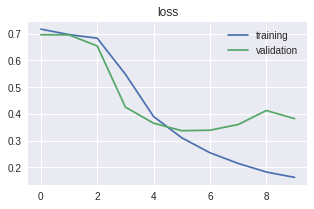

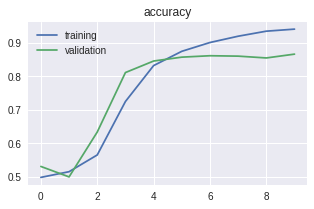

In [27]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'], label='training')
plt.plot(history.epoch,history.history['val_loss'], label='validation')
plt.title('loss')
plt.legend(loc='best')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['acc'], label='training')
plt.plot(history.epoch,history.history['val_acc'], label='validation')
plt.title('accuracy')
plt.legend(loc='best');

In [28]:
score, acc = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (acc*100))
print("Test score: %.2f%%" % (score*100))

Accuracy: 86.25%
Test score: 37.34%


0.86252
              precision    recall  f1-score   support

         pos       0.86      0.86      0.86     12500
         neg       0.86      0.86      0.86     12500

   micro avg       0.86      0.86      0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000

[[10783  1717]
 [ 1720 10780]]


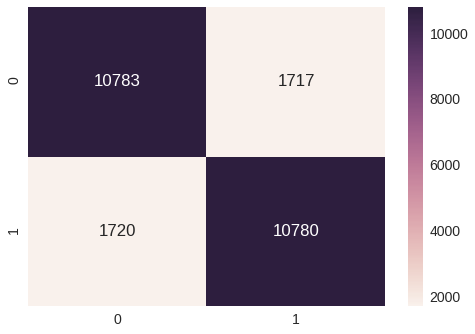

In [29]:
import pandas as pd
import seaborn as sns

from sklearn.metrics import classification_report,confusion_matrix
y_pred = model.predict_classes(np.array(x_test))

from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred))
target_names = ['pos', 'neg']
cnf_matrix_test = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred, target_names=target_names))
print(cnf_matrix_test)

df_cm = pd.DataFrame(cnf_matrix_test, range(2), range(2))

sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, fmt='d')

In [30]:
TP = cnf_matrix_test[1, 1]
TN = cnf_matrix_test[0, 0]
FP = cnf_matrix_test[0, 1]
FN = cnf_matrix_test[1, 0]

classification_error = (FP + FN) / float(TP + TN + FP + FN)
print(classification_error)

0.13748


### Transfer Learning

In [31]:
ls

cleanedfinancial_data.csv  glove.6B.200d.txt  glove.6B.50d.txt  sample_data/
glove.6B.100d.txt          glove.6B.300d.txt  glove.6B.zip


In [32]:
financial_data = pd.read_csv('cleanedfinancial_data.csv')
financial_data.iloc[2,1]

"Well, we need to bring the Shanghai factory online. I think that's the biggest driver for getting to 500K plus a year. Our car is just very expensive going into China. We've got import duties. We've got transport costs. We've got higher-cost labor here. And we've never been eligible for any of the EV tax credits. A lot of people sort of dependent on incentives. In fact, we are [indiscernible] EVs, we have the least access to incentives. It's pretty crazy because there's so many companies that - countries that have put price caps on the EV incentive, which affects Tesla. And in China, which is the biggest market for EVs, we've never had any subsidies or tax incentives for vehicles."

In [33]:
financial_test = financial_data[financial_data['sentiment'] != 'neutral']
financial_test['sentiment'] = financial_test['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [0]:
tokenizer = Tokenizer(num_words=1000)

financial_x_test = tokenizer.texts_to_matrix(financial_test['text'].tolist(), mode='freq')
financial_y_test = np.asarray(financial_test['sentiment'])

In [35]:
score, acc = model.evaluate(financial_x_test, financial_y_test, verbose=1)
print("Accuracy: %.2f%%" % (acc*100))
print("Test score: %.2f%%" % (score*100))

811/811 [==============================] - 0s 189us/step
Accuracy: 80.64%
Test score: 53.70%


0.8064118372379778
              precision    recall  f1-score   support

         pos       0.00      0.00      0.00       157
         neg       0.81      1.00      0.89       654

   micro avg       0.81      0.81      0.81       811
   macro avg       0.40      0.50      0.45       811
weighted avg       0.65      0.81      0.72       811

[[  0 157]
 [  0 654]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


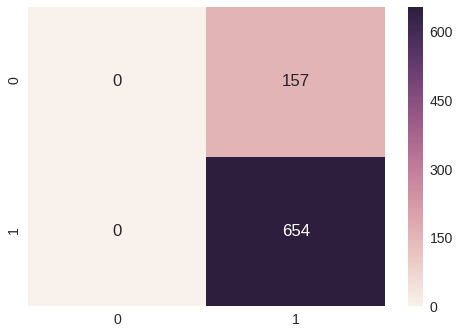

In [36]:
import pandas as pd
import seaborn as sns

from sklearn.metrics import classification_report,confusion_matrix
y_pred = model.predict_classes(np.array(financial_x_test))

from sklearn import metrics
print(metrics.accuracy_score(financial_y_test, y_pred))
target_names = ['pos', 'neg']
cnf_matrix_test = confusion_matrix(financial_y_test, y_pred)

print(classification_report(financial_y_test, y_pred, target_names=target_names))
print(cnf_matrix_test)

df_cm = pd.DataFrame(cnf_matrix_test, range(2), range(2))

sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, fmt='d')